# 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
import xgboost as xgb
import lightgbm as lgb

import missingno as msno

import os
from os.path import join

RAND_ST = 2023

## 데이터 불러오기, 데이터 특성 파악 및 전처리

In [2]:
# 데이터 경로 지정
train_data_path = join('data', 'train.csv')
sub_data_path = join('data', 'test.csv')

# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

# 데이터 형태 확인
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [3]:
# 라벨 데이터 별도 저장
y = data['price']
del data['price']

In [4]:
# 전체 데이터 확인
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))
print(data.head())

21503
   id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living1

<AxesSubplot:>

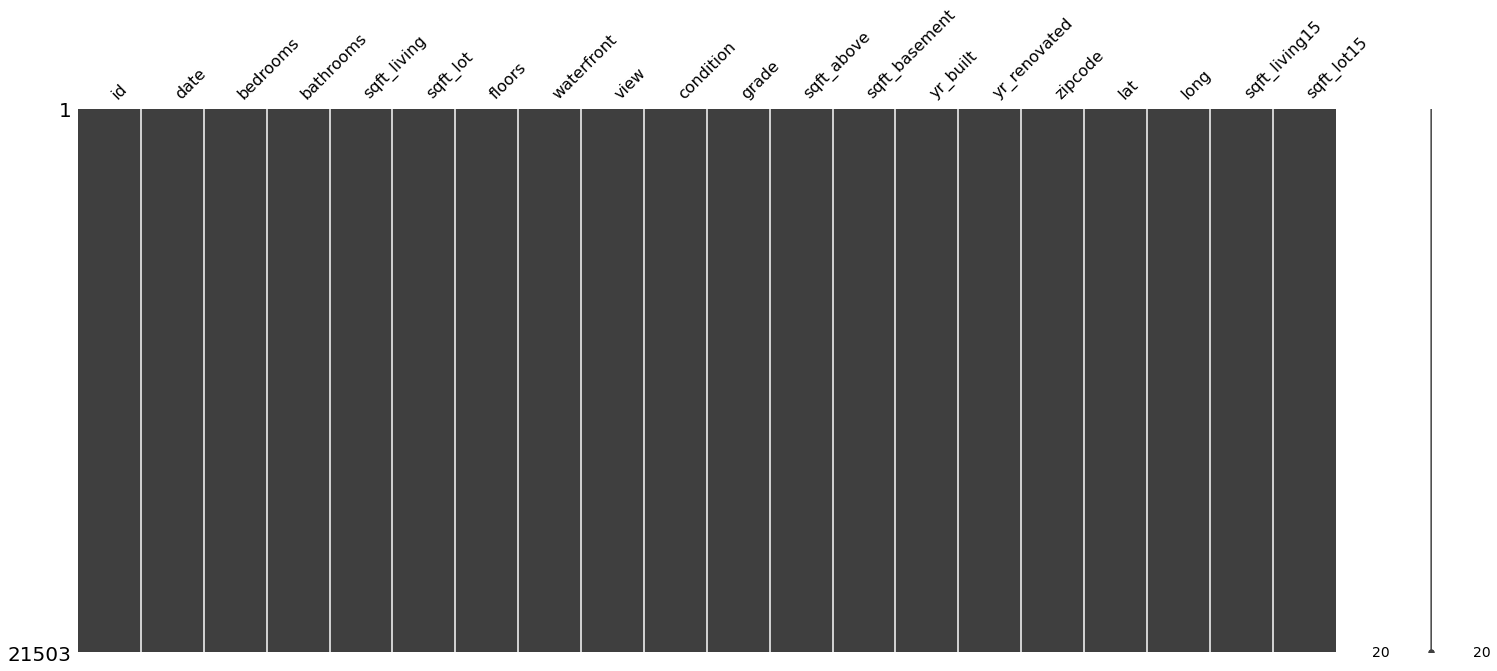

In [5]:
# 결측치 확인
msno.matrix(data)

In [6]:
# 항목별 결측치 개수 확인
for col in data.columns:
    miss = len(data[pd.isna(data[col])])
    print(f'Missing in {col}: {miss}')

Missing in id: 0
Missing in date: 0
Missing in bedrooms: 0
Missing in bathrooms: 0
Missing in sqft_living: 0
Missing in sqft_lot: 0
Missing in floors: 0
Missing in waterfront: 0
Missing in view: 0
Missing in condition: 0
Missing in grade: 0
Missing in sqft_above: 0
Missing in sqft_basement: 0
Missing in yr_built: 0
Missing in yr_renovated: 0
Missing in zipcode: 0
Missing in lat: 0
Missing in long: 0
Missing in sqft_living15: 0
Missing in sqft_lot15: 0


In [7]:
# id 컬럼 제거
del data['id']

In [8]:
# year, month 컬럼 추가
data['year'] = data['date'].apply(lambda d: d[:4]).astype(int)
data['month'] = data['date'].apply(lambda d: d[4:6]).astype(int)
data[['date', 'year','month']].head()

,date,year,month
0,20141013T000000,2014,10
1,20150225T000000,2015,2
2,20150218T000000,2015,2
3,20140627T000000,2014,6
4,20150115T000000,2015,1


In [9]:
# date 컬럼 제거
del data['date']

In [10]:
# 전체 컬럼 확인
columns = data.columns.values
print(columns)
print(len(columns))

['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement' 'yr_built'
 'yr_renovated' 'zipcode' 'lat' 'long' 'sqft_living15' 'sqft_lot15' 'year'
 'month']
20


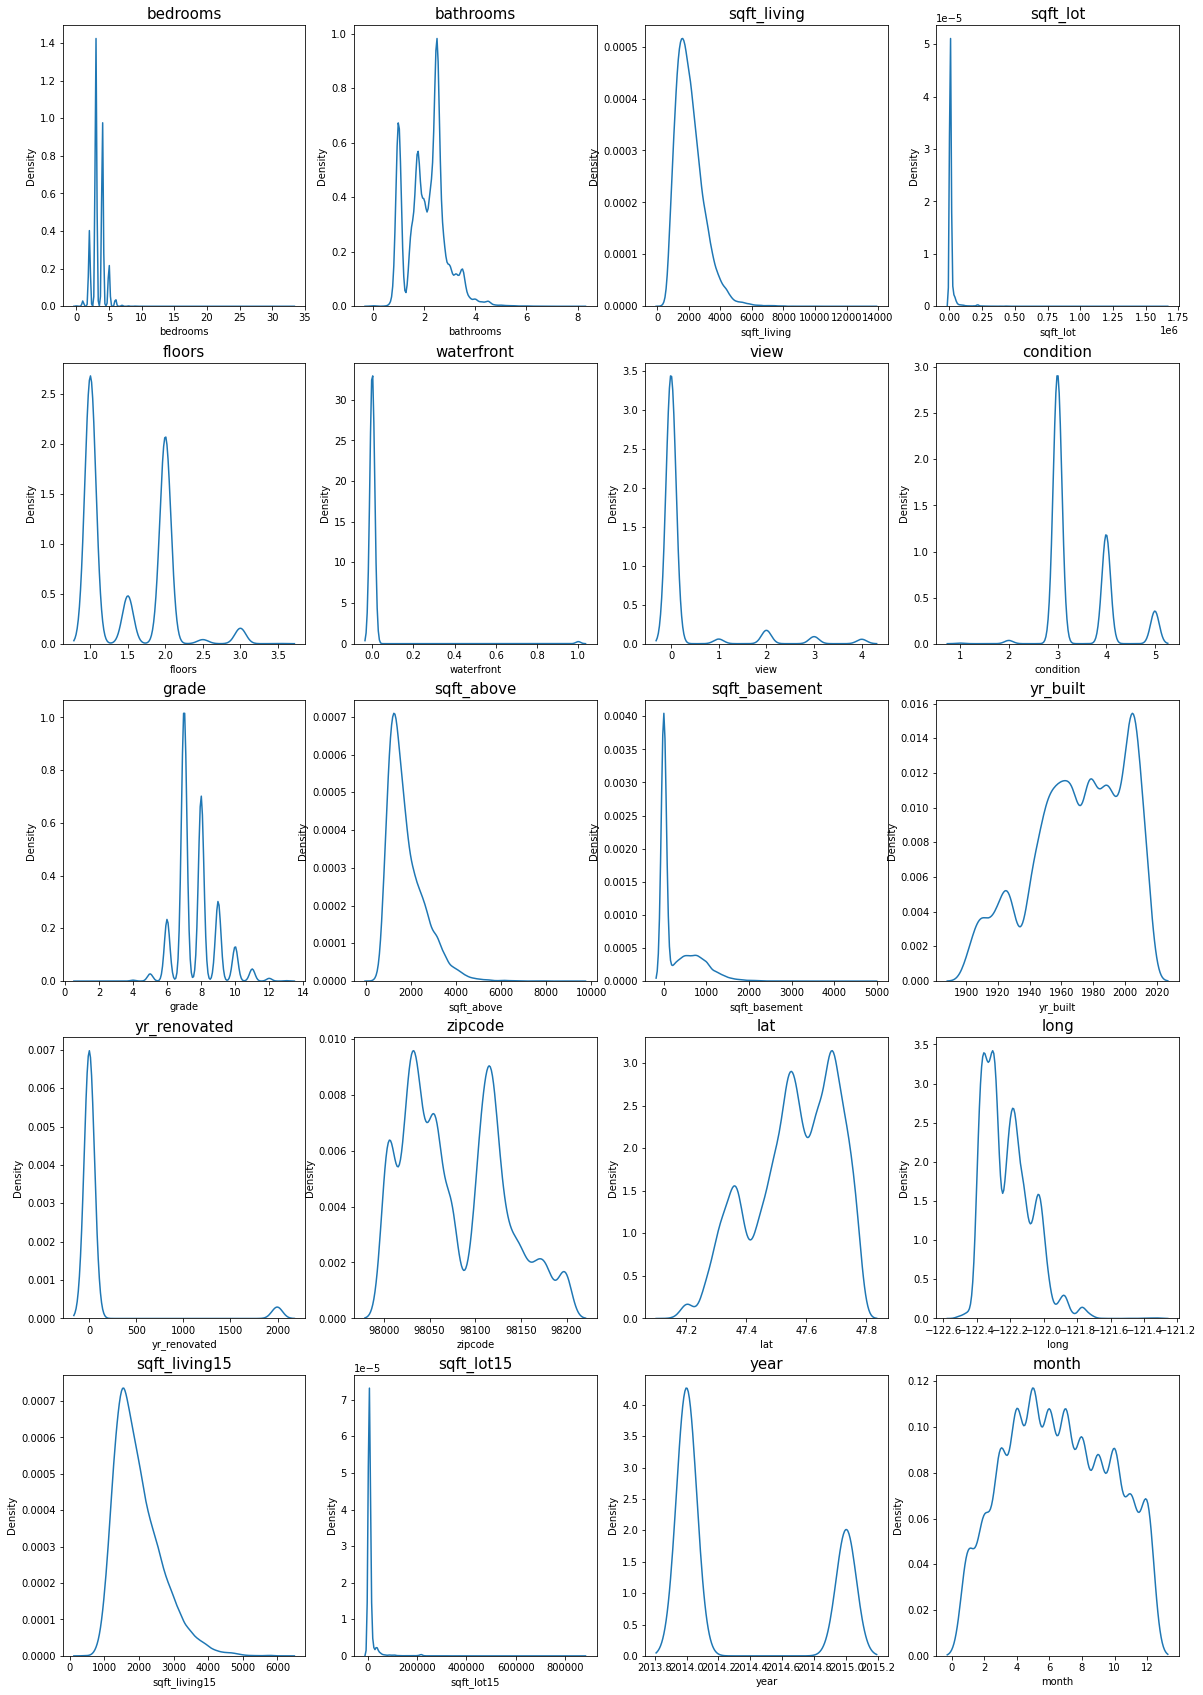

In [11]:
# 데이터 분포 시각화
fig, ax = plt.subplots(5, 4, figsize=(20, 30))

count = 0
for row in range(5):
    for col in range(4):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
plt.show()

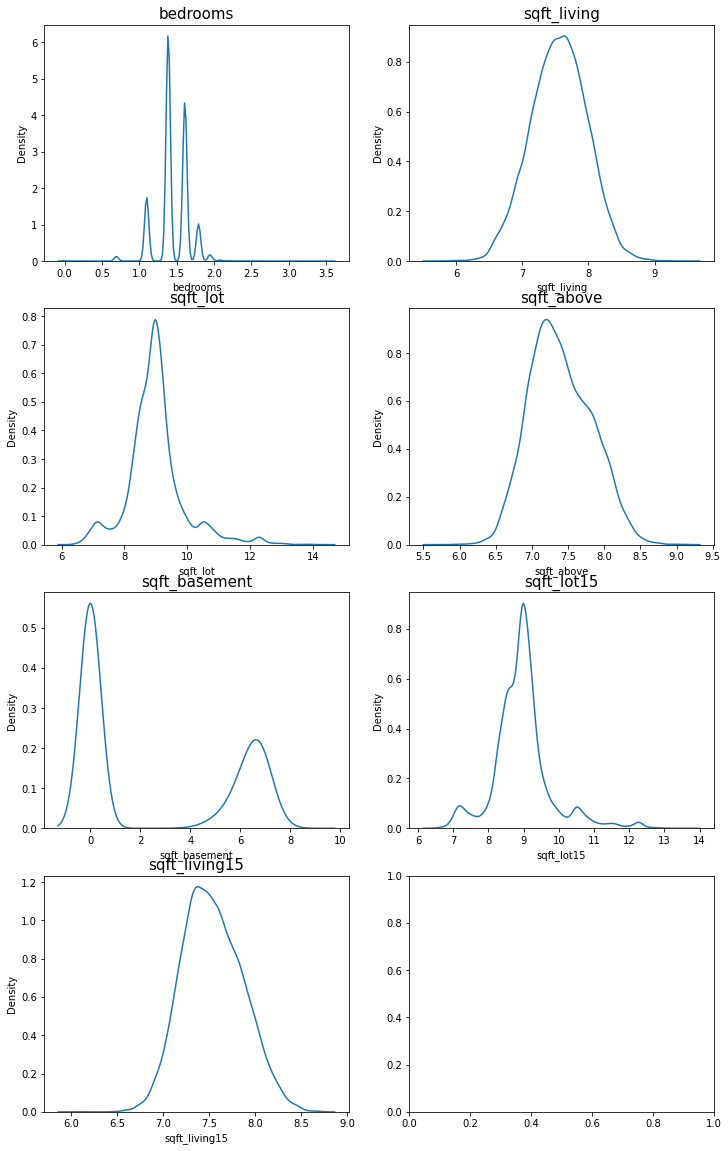

In [12]:
# 왼쪽으로 치우친 데이터 로그변환 및 시각화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    

fig, ax = plt.subplots(4, 2, figsize=(12, 20))

count = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

        if count == 7: break
plt.show()

In [13]:
# 데이터 다시 나누기

test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 20)
(6468, 20)


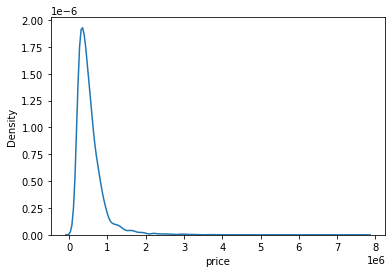

In [14]:
# 타겟 데이터 분포 확인
sns.kdeplot(y)
plt.show()

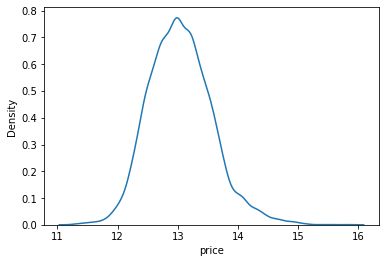

In [15]:
# 타겟 데이터 로그변환
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

## 학습 및 평가

In [16]:
# 학습 모델 설정

gboost = GradientBoostingRegressor(random_state=RAND_ST)
xgboost = xgb.XGBRegressor(random_state=RAND_ST)
lightgbm = lgb.LGBMRegressor(random_state=RAND_ST)
rdforest = RandomForestRegressor(random_state=RAND_ST)

param_grid_gb = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1],
    'max_depth': [1, 3, 5]
}

param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}

param_grid_lgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 10]
}

param_grid_rdf = {
    'n_estimators' : [10, 100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}



models = [{'model':gboost, 'name':'GradientBoosting', 'params': param_grid_gb},
          {'model':xgboost, 'name':'XGBoost', 'params': param_grid_xgb},
          {'model':lightgbm, 'name':'LightGBM', 'params': param_grid_lgb}, 
          {'model':rdforest, 'name':'RandomForest', 'params': param_grid_rdf}]

In [17]:
# 하이퍼파라미터 조합 탐색하는 함수

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results.sort_values('RMSLE', inplace=True)

    return results

In [18]:
# 모델별 하이퍼파라미터 탐색

dict_results = dict()

for dict_model in models:
    model = dict_model['model']
    param_grid = dict_model['params']
    name = dict_model['name']
    dict_results[name] = my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   6.7s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  29.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  17.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time= 1.3min
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  23.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time= 2.1min
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   4.6s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   5.2s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   4.6s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  29.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total

[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   5.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  32.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  15.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time= 1.5min
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  30.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time= 2.1min
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  30.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time= 1.3min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  28.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time= 2.2min
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=  13.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  27.4s
[CV] END ...learning_rate=0.

[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   6.8s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  32.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  15.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=500; total time= 1.2min
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  22.0s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time= 2.4min
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  25.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  15.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  16.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time= 1.3min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  24.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time= 2.1min
[CV] END ...learning_rate=0.

In [19]:
for key in dict_results.keys():
    print(key)
    print(dict_results[key])

GradientBoosting
    learning_rate  max_depth  n_estimators     score     RMSLE
5            0.05          5           500 -0.026716  0.163452
11           0.10          5           500 -0.026889  0.163980
9            0.10          3           500 -0.027747  0.166573
10           0.10          5           100 -0.028724  0.169481
3            0.05          3           500 -0.029225  0.170952
4            0.05          5           100 -0.031371  0.177120
8            0.10          3           100 -0.033502  0.183035
7            0.10          1           500 -0.039023  0.197544
2            0.05          3           100 -0.039813  0.199532
1            0.05          1           500 -0.043483  0.208525
6            0.10          1           100 -0.055039  0.234604
0            0.05          1           100 -0.074085  0.272186
XGBoost
    learning_rate  max_depth  n_estimators     score     RMSLE
11           0.10         10           100 -0.027455  0.165695
15           0.20          6  

In [20]:
# 최적의 파라미터로 모델 설정, Stacking Regressor 사용하여 학습

model_gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500, random_state=RAND_ST)
model_xgb = xgb.XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=RAND_ST)
model_lgb = lgb.LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=RAND_ST)
model_rdf = RandomForestRegressor(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=100, random_state=RAND_ST)

estimators = [('gb', model_gb), ('xgb', model_xgb), 
              ('lgb', model_lgb), ('rdf', model_rdf),
             ('lr', RidgeCV()), ('svr', LinearSVR(random_state=RAND_ST))] # 성능 향상을 위해 estimator 추가

reg = StackingRegressor(estimators=estimators)

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=RAND_ST)
reg.fit(X_train, y_train)


StackingRegressor(estimators=[('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         n_estimators=500,
                                                         random_state=2023)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_s...
                                            random_state=20

In [21]:
# 예측 및 평가

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

y_pred = reg.predict(X_test)
rmse = rmse(y_test, y_pred)
rmse

112290.51335030464

In [22]:
pred = np.expm1(reg.predict(test))

In [23]:
# 제출 파일 저장

submission_path = join('data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
submission['price'] = pred
submission.head()

,id,price
0,15035,5.041959e+05
1,15036,4.516839e+05
2,15037,1.355690e+06
3,15038,3.015606e+05
4,15039,3.275325e+05


In [26]:
submission.to_csv('submission.csv', index=False)

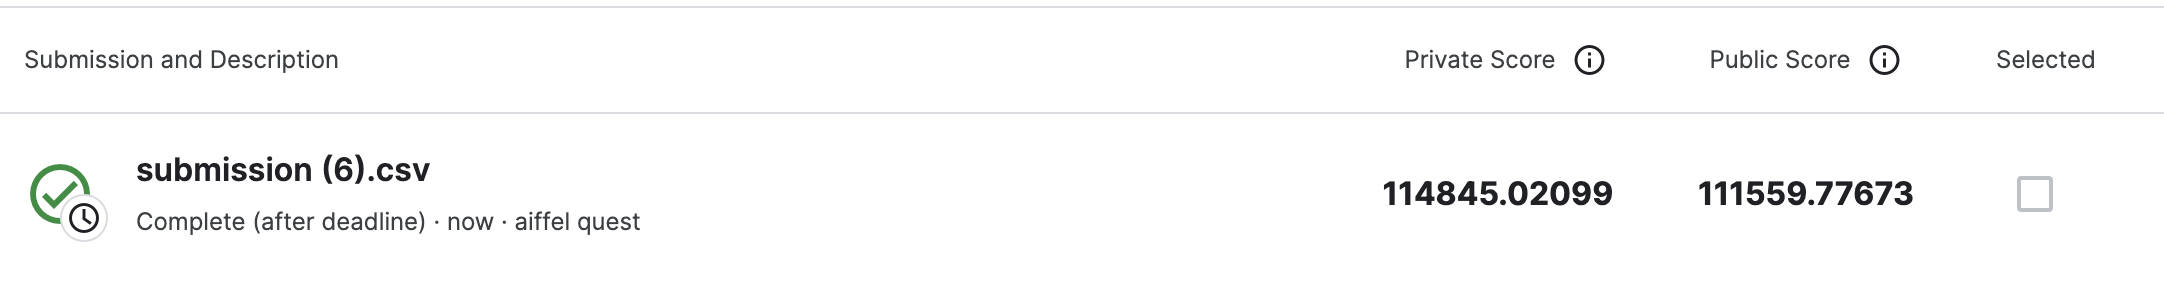

## 회고
- 성능 개선을 위해 고려해야 할 점이 아주 많다. 데이터 전처리와 학습 파트로 나누어서 생각하면 좋을 것 같다.
- 결과 확인 후 재실험을 위한 수정이 쉽도록 코드를 짜야겠다.